In [3]:
import os
import shutil
import random
import pickle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Corrected import
from tensorflow.keras.utils import to_categorical  # Correct import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.image import resize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


2024-04-05 13:08:10.335704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
# Load DenseNet121 pre-trained on imagenet.

model = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet')

2024-04-05 13:08:17.612093: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-05 13:08:17.625413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-05 13:08:18.269785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:bd:00.0 name: NVIDIA A100-SXM4-80GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.15GiB deviceMemoryBandwidth: 1.85TiB/s
2024-04-05 13:08:18.269819: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-04-05 13:08:18.277665: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-04-05 13:08:18.277700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [5]:
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

Adjust the model for CIFAR-10, resizing images, applying correct preprocessing, and modifying the top layer

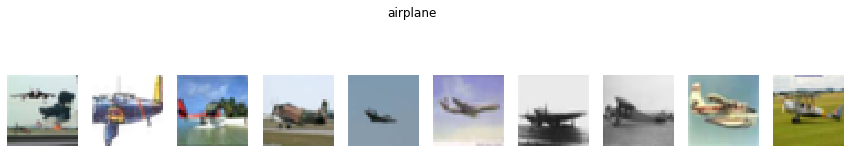

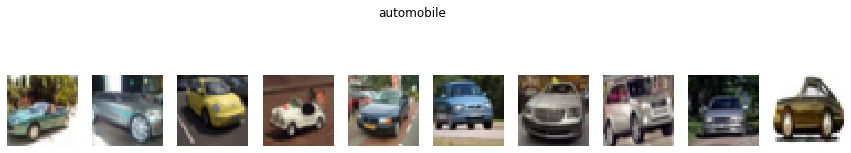

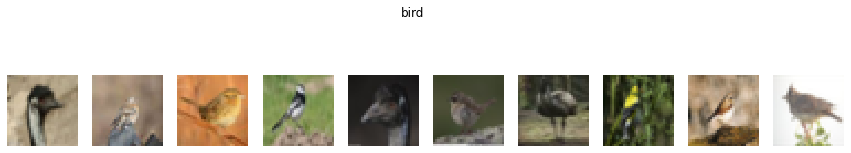

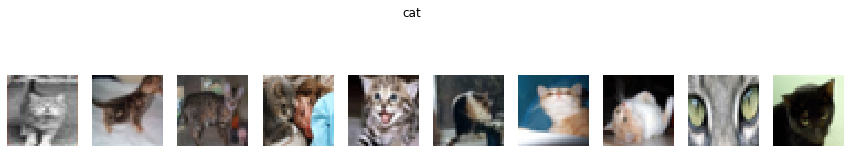

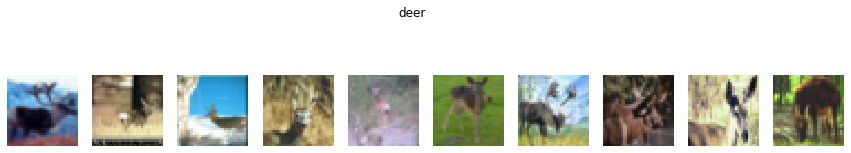

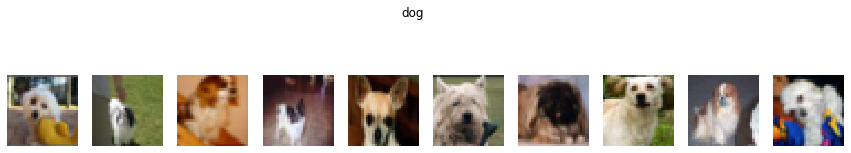

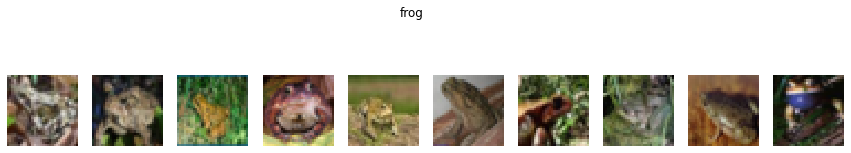

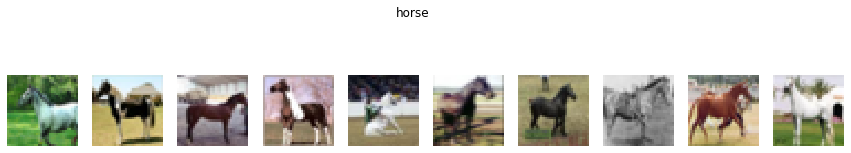

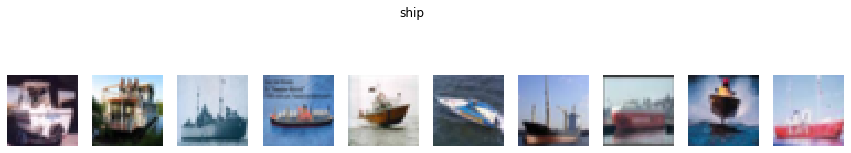

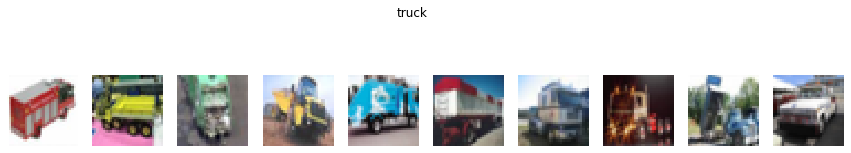

In [6]:
(x_train, y_train), (_, _) = cifar10.load_data()

# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to plot images
def plot_images(class_idx, class_name, x, y, num_samples=10):
    """
    This function plots 'num_samples' random images for a given class.
    
    Parameters:
    - class_idx: The index of the class (int).
    - class_name: The name of the class (str).
    - x: The image data (numpy array).
    - y: The labels (numpy array).
    - num_samples: The number of random samples to display (int).
    """
    plt.figure(figsize=(15, 3))
    plt.suptitle(class_name)
    
    # Get indexes of all images of the class
    idxs = np.flatnonzero(y == class_idx)
    
    # Randomly select 'num_samples' images
    random_idxs = np.random.choice(idxs, num_samples, replace=False)
    
    for i, idx in enumerate(random_idxs):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x[idx], interpolation='nearest')
        plt.axis('off')
    plt.show()

# Display 10 random images from each class
for i, class_name in enumerate(class_names):
    plot_images(i, class_name, x_train, y_train)


In [7]:
# Load DenseNet121 without the top layer (classifier)
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being updated during the first phase of training
base_model.trainable = False

# Add custom layers on top for CIFAR-10 classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(10, activation='softmax')(x)  # Add a logistic layer for 10 classes

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (should be done after setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

I used the CIFAR-10 dataset which is available through TensorFlow and can be loaded with a single function call. The dataset is split into training and testing sets, each containing images (x) and their corresponding labels (y).

In [8]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

One-hot encode the labels so that they match the expected format of the model's output.

In [9]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

Normalization is a crucial step that scales the image pixel values to a more manageable range for the neural network. Here, we convert the pixel values from integers in the range [0, 255] to floating-point values in the range [0, 1].

In [10]:
# Input image dimensions, etc.
resized_height = 224
resized_width = 224
num_channel = 3
num_classes = 14
batch_size = 128


def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [resized_height, resized_width])
    image = preprocess_input(image)  # Apply the preprocessing required for DenseNet

    # Ensure labels are flattened to work correctly with tf.one_hot
    label = tf.squeeze(label)  # Flatten label from (1,) to scalar
    label = tf.one_hot(label, depth=10)
    return image, label



# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create a dataset from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Preprocess the data: resize images and apply any other transformations
train_dataset = train_dataset.map(preprocess_image)
test_dataset = test_dataset.map(preprocess_image)

# Batch the data
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Prefetch the data for better performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


Add a custom classification head to the DenseNet121 base. This will add a few layers on top of the base model to make it suitable for classifying CIFAR-10 images into 10 categories.

In [11]:
# Load the DenseNet121 base model, excluding the top (classification) layer
base_model = tf.keras.applications.DenseNet121(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being updated during the first phase of training
base_model.trainable = False

# Add custom layers on top for CIFAR-10 classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert features to vectors
x = Dense(1024, activation='relu')(x)  # A dense layer for further learning
predictions = Dense(10, activation='softmax')(x)  # Final classification layer

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Train the model on the CIFAR-10 dataset. 

In [12]:
# Train the model
history = model.fit(train_dataset,
                    epochs=6,  # You can adjust the number of epochs based on your training needs
                    validation_data=test_dataset)


2024-04-05 13:09:12.620667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-05 13:09:12.632317: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2245715000 Hz


Epoch 1/6


2024-04-05 13:09:16.075009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-04-05 13:09:16.685781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-04-05 13:09:16.691828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-04-05 13:09:18.495994: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-04-05 13:09:18.665326: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  3/391 [..............................] - ETA: 23s - loss: 2.3461 - accuracy: 0.1710    

2024-04-05 13:13:09.957457: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 772s 1s/step - loss: 0.5676 - accuracy: 0.8050 - val_loss: 0.3704 - val_accuracy: 0.8739
Epoch 2/6
391/391 [==============================] - 67s 172ms/step - loss: 0.3110 - accuracy: 0.8917 - val_loss: 0.3189 - val_accuracy: 0.8900
Epoch 3/6
391/391 [==============================] - 67s 171ms/step - loss: 0.2641 - accuracy: 0.9097 - val_loss: 0.3063 - val_accuracy: 0.8939
Epoch 4/6
391/391 [==============================] - 67s 171ms/step - loss: 0.2280 - accuracy: 0.9229 - val_loss: 0.3108 - val_accuracy: 0.8946
Epoch 5/6
391/391 [==============================] - 67s 172ms/step - loss: 0.1956 - accuracy: 0.9330 - val_loss: 0.3108 - val_accuracy: 0.8967
Epoch 6/6
391/391 [==============================] - 68s 174ms/step - loss: 0.1666 - accuracy: 0.9433 - val_loss: 0.3373 - val_accuracy: 0.8911


Plot both the training and validation loss, as well as the accuracy, to see how the model performed over epochs.

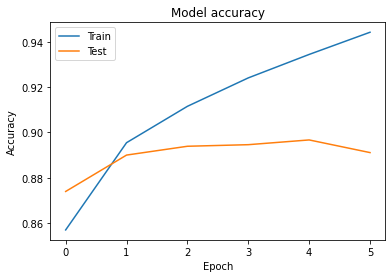

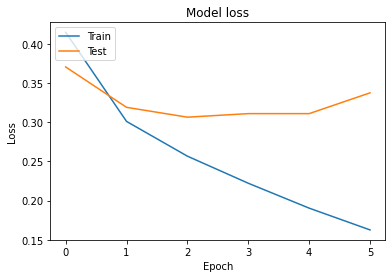

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [14]:
# Final evaluation on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


79/79 [==============================] - 11s 144ms/step - loss: 0.3373 - accuracy: 0.8911
Test Loss: 0.3373408913612366, Test Accuracy: 0.8910999894142151


The DenseNet121 model demonstrated significant learning efficiency and capacity for feature extraction and classification accuracy improvement over epochs. Initial epochs showed a rapid decrease in training loss accompanied by a substantial increase in accuracy, indicating effective learning from the training dataset.

The validation results corroborated the model's ability to generalize well to unseen data, as evidenced by a consistent increase in validation accuracy. The slight increase in validation loss in later epochs suggests the onset of overfitting.

The training process was characterized by leveraging DenseNet121's feature extraction capabilities, fine-tuned with a custom classification head to suit the CIFAR-10 dataset. Through iterative backpropagation and optimization (using the RMSprop algorithm), the model's weights were adjusted to minimize the categorical cross-entropy loss, effectively increasing classification accuracy on both training and validation datasets.

Despite the overfitting indications, the overall training and validation performance metrics suggest that the model, with appropriate regularization techniques and hyperparameter tuning, holds potential for high precision image classification tasks. Data augmentation, dropout, and early stopping, alongside fine-tuning of the model with unfrozen layers of the pre-trained DenseNet121, could further enhance the model's performance and its ability to generalize to new, unseen data.

Make Predictions:
    Iterate over batched dataset to collect all predictions and true labels.

Calculate Precision, Recall, and F1 Score

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Reiterate over the test dataset to obtain predictions and true labels correctly
y_pred = []
y_true = []

# Make sure to use the correct dataset
for image_batch, label_batch in test_dataset.unbatch().batch(1):
    preds = model.predict(image_batch)
    preds = np.argmax(preds, axis=1)
    true = np.argmax(label_batch, axis=1)  # Assuming labels are one-hot encoded
    y_pred.extend(preds)
    y_true.extend(true)

# Convert to numpy arrays for compatibility with scikit-learn utilities
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Now, generate the classification report again
print(classification_report(y_true, y_pred, target_names=class_names))



              precision    recall  f1-score   support

    airplane       0.87      0.96      0.91      1000
  automobile       0.88      0.97      0.93      1000
        bird       0.92      0.86      0.89      1000
         cat       0.76      0.86      0.80      1000
        deer       0.84      0.90      0.87      1000
         dog       0.89      0.84      0.87      1000
        frog       0.98      0.85      0.91      1000
       horse       0.88      0.95      0.91      1000
        ship       0.97      0.88      0.92      1000
       truck       0.98      0.84      0.91      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



Generate and Plot the Confusion Matrix

Confusion matrix, without normalization


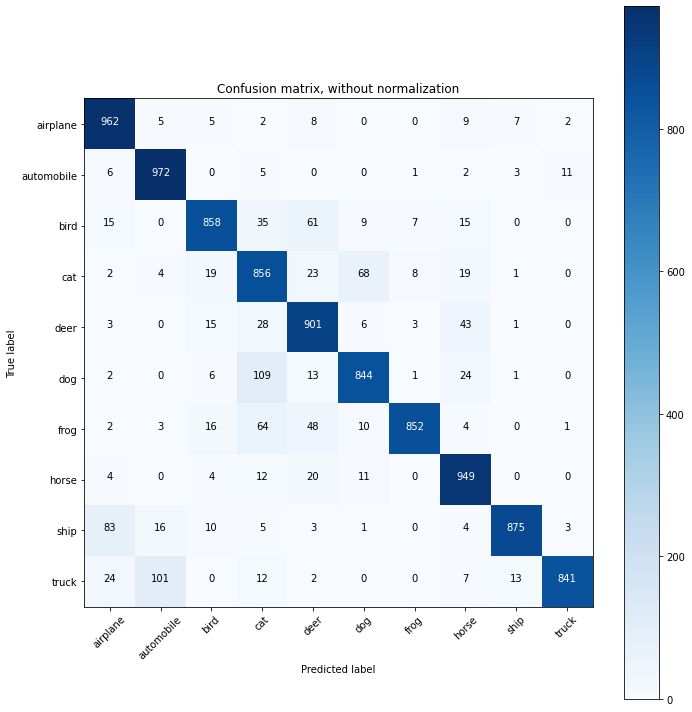

In [17]:
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, class_names, title='Confusion matrix, without normalization')


The DenseNet121 model, adapted and fine-tuned for the CIFAR-10 dataset, has demonstrated commendable performance across the board, as reflected in the detailed classification metrics. With an overall accuracy of 89%, the model showcases a balanced capability in distinguishing among the ten diverse classes that comprise the dataset. Notably, the model excels in identifying and classifying 'ship' and 'truck' classes, achieving precision scores of 0.97 and 0.98 respectively. This high precision indicates a strong reliability in the model's predictions for these particular classes, suggesting that when the model predicts an image as belonging to either 'ship' or 'truck,' it is correct with very high probability.

Conversely, the model experiences some challenges with the 'cat' class, where precision is notably lower at 0.76, although the recall for 'cat' is relatively high at 0.86. This suggests that while the model is quite adept at recognizing the majority of 'cat' instances presented to it, there's a higher tendency for false positives in this class compared to others. Similarly, for 'dog,' with a precision of 0.89 and a recall of 0.84, it indicates a slightly lesser challenge but still points towards a need for improvement in distinguishing these particular animal classes with higher fidelity.

Classes such as 'airplane' and 'automobile' exhibit high recall values of 0.96 and 0.97, respectively, indicating the model's effectiveness in identifying most instances of these classes within the dataset. The 'frog' class, while achieving a high precision of 0.98, sees a lower recall of 0.85, suggesting a small portion of 'frog' instances might be overlooked or misclassified as belonging to other classes.

The nuanced performances, characterized by varying degrees of precision and recall across classes, indicate a sophisticated model behavior that is more attuned to certain patterns and characteristics inherent to specific classes. For instance, the model's high precision in 'ship' and 'truck' could be attributed to distinct, easily recognizable features unique to these classes that are captured effectively through DenseNet121's deep convolutional layers.

In summary, the DenseNet121 model presents a highly competent classification performance on the CIFAR-10 dataset, demonstrating its robust feature extraction and learning capabilities. Nonetheless, the nuanced discrepancies across different classes, especially between those with high precision and lower recall or vice versa, underscore the potential areas for further model refinement. Enhancements such as data augmentation, class weighting, or even exploring more complex or customized architectures could potentially address these disparities, leading to even higher accuracy and a more uniformly distributed precision and recall across all classes.